# TREC

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim.downloader
import time

In [2]:
# Load training and development datasets
df_train=pd.read_csv("../datasets/TREC/train.csv")
df_train["text"] = df_train["text"].str.lower()

# Load test dataset
df_test=pd.read_csv("../datasets/TREC/test.csv")
df_test["text"] = df_test["text"].str.lower()

In [3]:
# Split the training dataset to create a development set of 500 examples
train_data, dev_data = train_test_split(df_train, test_size=500, random_state=42)

# Rename the test dataset to synchronize the namings
test_data = df_test

len(train_data), len(dev_data), len(test_data)

(4952, 500, 500)

## Update Word2Vec

In [4]:
# Download the "glove-twitter-25" embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

In [5]:
# Out-of-vocabulary (OOV) words
# 1. can be replaced with a special token, such as "<OOV>" or "<UNK>"
# 2. can be ignored

word2idx = w2v.key_to_index

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001


In [6]:
# Add the '<UNK>' word to the vocabulary of the Word2Vec model 
# Initialize it with the average of all word vectors int he pretrained embeddings
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])
print("after insert UNK: ", w2v.vectors.shape)

# Add the '<PAD>' word to the vocabulary of the Word2Vec model 
# Initialize it with a row of zeros in the vectors matrix
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])
print("after insert UNK: ", w2v.vectors.shape)

after insert UNK:  (3000001, 300)
after insert UNK:  (3000002, 300)


## Modify Class Labels

In [7]:
# Get unique coarse labels
unique_labels = train_data['label-coarse'].unique()

# Randomly select 4 classes
np.random.seed(19260817)
selected_labels = np.random.choice(unique_labels, size=4, replace=False)

# ****** 6 == OTHERS !!!!!! IMPORTANT 
# update: 6 will cause error, change back to OTHERS then transform later

train_data['new_label'] = train_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
dev_data['new_label'] = dev_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
test_data['new_label'] = test_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")

# Display the unique labels in the updated training set
train_data['new_label'].unique()

array([2, 0, 'OTHERS', 4, 3], dtype=object)

In [8]:
# Encode labels for easier reference in the following part
label_encoder = LabelEncoder()

test_data['new_label'] = test_data['new_label'].astype(str)
test_data["label_transformed"] = label_encoder.fit_transform(test_data['new_label'])

train_data['new_label'] = train_data['new_label'].astype(str)
train_data["label_transformed"] = label_encoder.fit_transform(train_data['new_label'])

dev_data['new_label'] = dev_data['new_label'].astype(str)
dev_data["label_transformed"] = label_encoder.fit_transform(dev_data['new_label'])

In [9]:
train_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
4943,2,34,what is mikhail gorbachev 's middle initial ?,2,1
2346,0,0,how does the tail affect the flight of a kite ?,0,0
1835,5,21,what were the first three cities to have a pop...,OTHERS,4
4047,1,1,what is the movie jonathan livingstone seagull ?,OTHERS,4
5097,1,23,what is a fear of home surroundings ?,OTHERS,4


In [10]:
dev_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
3408,5,21,what city is served by tempelhol airport ?,OTHERS,4
371,1,2,what is dudley do-right 's horse 's name ?,OTHERS,4
453,0,9,what 's nature 's purpose for tornadoes ?,0,0
290,0,12,what is the history of valentine 's day cards ?,0,0
4457,3,4,what president became chief justice after his ...,3,2


In [11]:
test_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
0,4,40,how far is it from denver to aspen ?,4,3
1,5,21,"what county is modesto , california in ?",OTHERS,4
2,3,12,who was galileo ?,3,2
3,0,7,what is an atom ?,0,0
4,4,8,when did hawaii become a state ?,4,3


## Handle Out of Vocabulary and Pad Sentence (i.e. Add \<UNK> && \<PAD>)

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]

class TRECDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.labels = [torch.tensor(label) for label in labels]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

def collate_fn(batch):
    sentences, labels = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    return sentences_padded, labels

# Create PyTorch datasets and data loaders
train_dataset = TRECDataset(train_data['text'], train_data['label_transformed'], word2idx)
dev_dataset = TRECDataset(dev_data['text'], dev_data['label_transformed'], word2idx)
test_dataset = TRECDataset(test_data['text'], test_data['label_transformed'], word2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Training, Evaluation and Visualization function

**Since Dataloader is fixed, try to use below functions for easy-training-implementation**

In [13]:
from sklearn.metrics import f1_score

In [14]:
def train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience):
    train_losses = []
    dev_losses = []
    train_accuracies = []
    dev_accuracies = []
    y_true = []
    y_pred = []
    best_accuracy = 0.0
    no_improvement_count = 0
    
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for sentences, label_tuple in train_loader:
            model.zero_grad()
            labels = torch.stack(label_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(total_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        dev_loss = 0
        correct_dev = 0
        total_dev = 0
        with torch.no_grad():
            for sentences, label_tuple in dev_loader:
                labels = torch.stack(label_tuple)
                predictions = model(sentences)
                
                loss = loss_function(predictions, labels)
                dev_loss += loss.item()
                
                _, predicted = torch.max(predictions, 1)
                total_dev += labels.size(0)
                correct_dev += (predicted == labels).sum().item()
                
                y_true.extend(labels)
                y_pred.extend(predicted)
        
        dev_accuracy = 100 * correct_dev / total_dev
        dev_accuracies.append(dev_accuracy)
        dev_losses.append(dev_loss/len(dev_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Dev Accuracy: {dev_accuracies[-1]:.2f}%")
        
        # Compute F1 score
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')
        print("Macro F1 Score:", f1_macro)
        print("Micro F1 Score:", f1_micro)
        
        # Early stopping
        if dev_accuracy > best_accuracy:
            best_accuracy = dev_accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping after {epoch+1} epochs with no improvement.')

            end_time = time.time()
            total_train_time = end_time - start_time
            print(f'Total training time: {total_train_time:.2f} seconds.')
            break
    
    end_time = time.time()
    total_train_time = end_time - start_time
    print(f'Total training time: {total_train_time:.2f} seconds.')

    return train_losses, dev_losses, train_accuracies, dev_accuracies

In [15]:
def evaluate_model(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        for sentences, tag_tuple in test_loader:
            labels = torch.stack(tag_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            y_true_test.extend(labels)
            y_pred_test.extend(predicted)

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Compute F1 score
    f1_test_macro = f1_score(y_true_test, y_pred_test, average='macro')
    f1_test_micro = f1_score(y_true_test, y_pred_test, average='micro')
    print("Macro F1 Score on Test Set:", f1_test_macro)
    print("Micro F1 Score on Test Set:", f1_test_micro)

    return test_loss, test_accuracy

In [16]:
def visualize(train_losses, dev_losses, train_accuracies, dev_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, dev_losses, 'r*-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, dev_accuracies, 'r*-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [17]:
# Load embedding layer
weights = torch.FloatTensor(w2v.vectors)

# Build nn.Embedding() layer
embedding = nn.Embedding.from_pretrained(weights)
# embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=vocab.get('<PAD>', None), freeze=True)
embedding.requires_grad = False

embedding_matrix = torch.FloatTensor(w2v.vectors)

## Model 1
Hidden layer: Simple linear layer\
Aggregation Method: Average pooling over the word vectors

In [18]:
# Define model 1 architecture
class QuestionClassifierModel1(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifierModel1, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)

        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [19]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5

model = QuestionClassifierModel1(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 150
patience = 5

/p/scratch/ccstdl/xu17/miniconda3/envs/jz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/150, Train Loss: 1.4062, Dev Loss: 1.3819, Train Accuracy: 38.17%, Dev Accuracy: 39.20%
Macro F1 Score: 0.11615771615771615
Micro F1 Score: 0.39200000000000007
Epoch 2/150, Train Loss: 1.3616, Dev Loss: 1.3709, Train Accuracy: 38.69%, Dev Accuracy: 39.80%
Macro F1 Score: 0.12779068043682365
Micro F1 Score: 0.395
Epoch 3/150, Train Loss: 1.3491, Dev Loss: 1.3700, Train Accuracy: 39.84%, Dev Accuracy: 41.80%
Macro F1 Score: 0.1688592454224515
Micro F1 Score: 0.4026666666666667
Epoch 4/150, Train Loss: 1.3375, Dev Loss: 1.3552, Train Accuracy: 41.05%, Dev Accuracy: 43.00%
Macro F1 Score: 0.18043873905433422
Micro F1 Score: 0.4095
Epoch 5/150, Train Loss: 1.3323, Dev Loss: 1.3579, Train Accuracy: 41.40%, Dev Accuracy: 40.20%
Macro F1 Score: 0.19235823301505528
Micro F1 Score: 0.408
Epoch 6/150, Train Loss: 1.3228, Dev Loss: 1.3551, Train Accuracy: 42.61%, Dev Accuracy: 41.40%
Macro F1 Score: 0.20106065316140947
Micro F1 Score: 0.409
Epoch 7/150, Train Loss: 1.3159, Dev Loss: 1.3455

In [21]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.3514, Test Accuracy: 37.20%
Macro F1 Score on Test Set: 0.235297951407982
Micro F1 Score on Test Set: 0.372


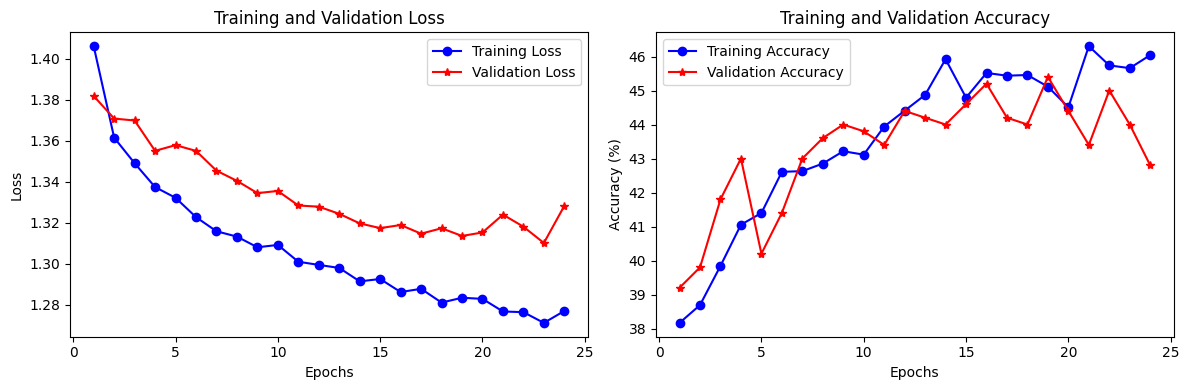

In [22]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 2
Hidden Layer Design: Simple linear layer\
Aggregation Method: Max pooling over the word vectors

### Intend to do: The max pooling method applied here is basically max-pooling over filters
e.g. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[1,2,3,4\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[2,0,4,8\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[9,0,2,1\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;|&nbsp;&nbsp;|&nbsp;&nbsp;|\
result: \[9,2,4,8\]
#### To introduce more randomness, we can choose to apply the max-pooling on a portion of randomly selected slots 

### The following implementation is simply doing 1D max pooling over a flattened sentence

In [23]:
# Define model 2 architecture
class QuestionClassifierModel2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, sample_percent):
        super(QuestionClassifierModel2, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.sample_percent = sample_percent
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Max pooling over the word vectors
        sentence_len = list(x.size())[1]
        x = torch.flatten(x, start_dim=1)
        max_pooling = nn.MaxPool1d(sentence_len, stride=sentence_len)
        x = max_pooling(x) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim

        return x
    
#         The following implementation is the one that I described as intended in the heading
#         However, the performance is too bad that I commented it out first

#         original_tensor = x

#         # Determine the number of elements to extract based on the portion
#         num_elements = original_tensor.size(1)
#         num_elements_to_extract = int(num_elements * self.sample_percent)

#         # Generate random indices for sampling without replacement
#         random_indices = torch.randperm(num_elements)[:num_elements_to_extract]

#         # Use the random indices to extract the sampled data
#         sampled_data = original_tensor[:, random_indices, :]
#         pooled_data, _ = torch.max(sampled_data, dim=1)

#         x = self.output(pooled_data)  # Now, shape: batch_size x output_dim

In [24]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
MAX_POOLING_SAMPLE_PERCENT = 0.8

model = QuestionClassifierModel2(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, MAX_POOLING_SAMPLE_PERCENT)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
patience = 5

In [25]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/100, Train Loss: 1.3764, Dev Loss: 1.3206, Train Accuracy: 38.61%, Dev Accuracy: 45.80%
Macro F1 Score: 0.3026227460866341
Micro F1 Score: 0.458
Epoch 2/100, Train Loss: 1.2489, Dev Loss: 1.2506, Train Accuracy: 47.74%, Dev Accuracy: 51.80%
Macro F1 Score: 0.34512098828981336
Micro F1 Score: 0.488
Epoch 3/100, Train Loss: 1.1770, Dev Loss: 1.2165, Train Accuracy: 53.43%, Dev Accuracy: 55.00%
Macro F1 Score: 0.3611011646411013
Micro F1 Score: 0.5086666666666667
Epoch 4/100, Train Loss: 1.1485, Dev Loss: 1.2022, Train Accuracy: 56.02%, Dev Accuracy: 55.40%
Macro F1 Score: 0.3728764657006944
Micro F1 Score: 0.52
Epoch 5/100, Train Loss: 1.1181, Dev Loss: 1.1941, Train Accuracy: 56.93%, Dev Accuracy: 54.20%
Macro F1 Score: 0.37736625691028286
Micro F1 Score: 0.5244
Epoch 6/100, Train Loss: 1.0910, Dev Loss: 1.1799, Train Accuracy: 58.58%, Dev Accuracy: 56.20%
Macro F1 Score: 0.38450071371446287
Micro F1 Score: 0.5306666666666666
Epoch 7/100, Train Loss: 1.0931, Dev Loss: 1.1740, Tr

In [26]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.1829, Test Accuracy: 50.00%
Macro F1 Score on Test Set: 0.3480988071757302
Micro F1 Score on Test Set: 0.5


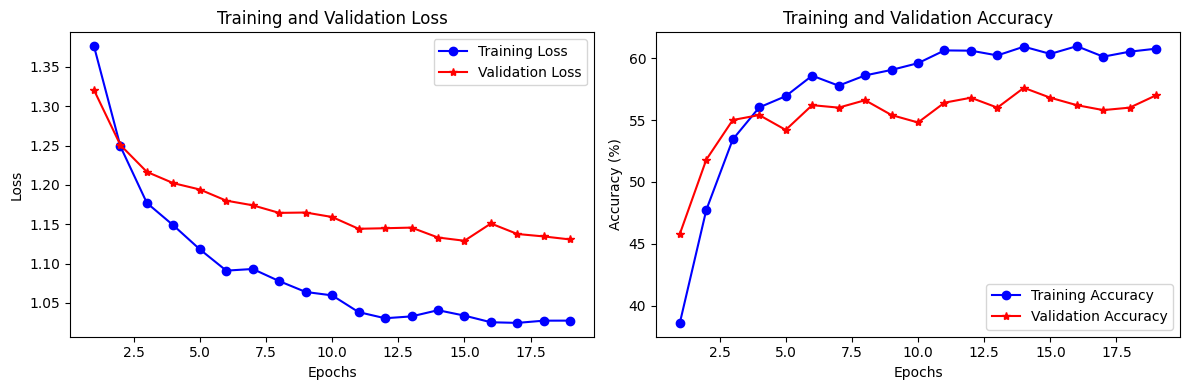

In [27]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 3.1
Hidden Layer Design: Recurrent neural network (RNN)\
Aggregation Method: Using the representation of the last word (RNN-based)

In [28]:
# Define model 3.1 architecture
class QuestionClassifierModel3_1(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel3_1, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the representation of the last word
        out, hidden = self.hidden(x)
        x = hidden[0] # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [29]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel3_1(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
patience = 5

In [30]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/50, Train Loss: 1.4065, Dev Loss: 1.4086, Train Accuracy: 37.74%, Dev Accuracy: 38.60%
Macro F1 Score: 0.11873881932021466
Micro F1 Score: 0.386
Epoch 2/50, Train Loss: 1.3954, Dev Loss: 1.4057, Train Accuracy: 38.25%, Dev Accuracy: 38.60%
Macro F1 Score: 0.12222222222222223
Micro F1 Score: 0.386
Epoch 3/50, Train Loss: 1.3942, Dev Loss: 1.4083, Train Accuracy: 38.43%, Dev Accuracy: 39.00%
Macro F1 Score: 0.1236845727966482
Micro F1 Score: 0.3873333333333333
Epoch 4/50, Train Loss: 1.3929, Dev Loss: 1.4108, Train Accuracy: 38.59%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12279198777261331
Micro F1 Score: 0.388
Epoch 5/50, Train Loss: 1.3906, Dev Loss: 1.4120, Train Accuracy: 38.41%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12213000418468405
Micro F1 Score: 0.388
Epoch 6/50, Train Loss: 1.3912, Dev Loss: 1.4099, Train Accuracy: 38.31%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12177042801556422
Micro F1 Score: 0.3883333333333333
Epoch 7/50, Train Loss: 1.3944, Dev Loss: 1.4081, Train A

In [31]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.4846, Test Accuracy: 34.80%
Macro F1 Score on Test Set: 0.11410766542453525
Micro F1 Score on Test Set: 0.348


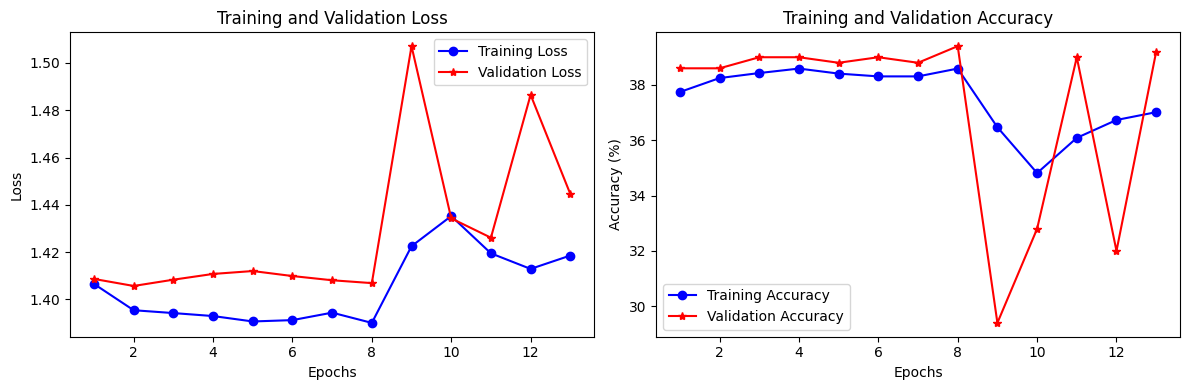

In [32]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 3.2
Hidden Layer Design: Recurrent neural network (RNN)\
Aggregation Method: Using the representation of the average of all the hidden layers (RNN-based)

In [33]:
# Define model 3.2 architecture
class QuestionClassifierModel3_2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel3_2, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the representation of the last word
        out, hidden = self.hidden(x)
        x = torch.mean(hidden, dim=0) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [34]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel3_2(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
patience = 5

In [35]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/50, Train Loss: 1.4101, Dev Loss: 1.4145, Train Accuracy: 37.70%, Dev Accuracy: 39.00%
Macro F1 Score: 0.11223021582733812
Micro F1 Score: 0.39
Epoch 2/50, Train Loss: 1.3942, Dev Loss: 1.4144, Train Accuracy: 38.31%, Dev Accuracy: 39.20%
Macro F1 Score: 0.11636667089962449
Micro F1 Score: 0.391
Epoch 3/50, Train Loss: 1.3941, Dev Loss: 1.4076, Train Accuracy: 38.39%, Dev Accuracy: 38.80%
Macro F1 Score: 0.11738858401035472
Micro F1 Score: 0.39
Epoch 4/50, Train Loss: 1.3931, Dev Loss: 1.4115, Train Accuracy: 38.45%, Dev Accuracy: 38.40%
Macro F1 Score: 0.11764760096098034
Micro F1 Score: 0.3885
Epoch 5/50, Train Loss: 1.3941, Dev Loss: 1.4134, Train Accuracy: 38.07%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12012196345108424
Micro F1 Score: 0.3884
Epoch 6/50, Train Loss: 1.3911, Dev Loss: 1.4131, Train Accuracy: 38.35%, Dev Accuracy: 38.60%
Macro F1 Score: 0.11990558213716107
Micro F1 Score: 0.388
Epoch 7/50, Train Loss: 1.3932, Dev Loss: 1.4149, Train Accuracy: 38.19%, Dev Accu

In [36]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.4414, Test Accuracy: 34.60%
Macro F1 Score on Test Set: 0.10840085287846483
Micro F1 Score on Test Set: 0.346


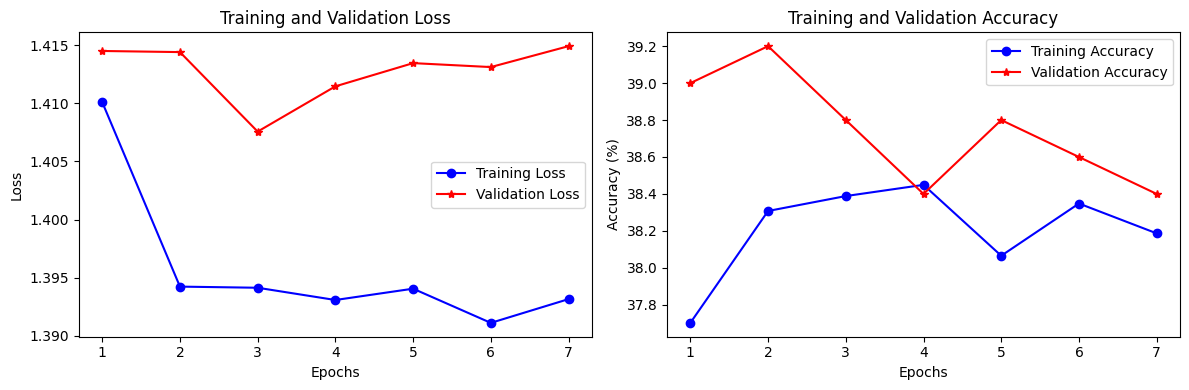

In [37]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 4.1
Hidden Layer Design: Hierarchical LSTM (LSTM at both word and sentence levels)\
Aggregation Method: Using the representation of the average of all the hidden layers

In [38]:
# Define model 4.1 architecture
class QuestionClassifierModel4_1(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel4_1, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the mean of the hidden layers as the final representation
        out, (hidden, cell) = self.hidden(x)
        x = torch.mean(hidden, dim=0) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [39]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel4_1(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
patience = 5

In [40]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/100, Train Loss: 1.4089, Dev Loss: 1.4333, Train Accuracy: 37.24%, Dev Accuracy: 38.80%
Macro F1 Score: 0.13988114769040066
Micro F1 Score: 0.388
Epoch 2/100, Train Loss: 1.3866, Dev Loss: 1.3858, Train Accuracy: 38.23%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12780058651026394
Micro F1 Score: 0.389
Epoch 3/100, Train Loss: 1.3774, Dev Loss: 1.4071, Train Accuracy: 37.86%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12822161368416876
Micro F1 Score: 0.38866666666666666
Epoch 4/100, Train Loss: 1.3720, Dev Loss: 1.3841, Train Accuracy: 38.89%, Dev Accuracy: 41.20%
Macro F1 Score: 0.16738859672472312
Micro F1 Score: 0.3945000000000001
Epoch 5/100, Train Loss: 1.3699, Dev Loss: 1.3879, Train Accuracy: 40.39%, Dev Accuracy: 42.20%
Macro F1 Score: 0.18282368069245236
Micro F1 Score: 0.4000000000000001
Epoch 6/100, Train Loss: 1.3613, Dev Loss: 1.3702, Train Accuracy: 40.35%, Dev Accuracy: 41.20%
Macro F1 Score: 0.18594428198423998
Micro F1 Score: 0.402
Epoch 7/100, Train Loss: 1.3666, Dev

In [41]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.2516, Test Accuracy: 54.80%
Macro F1 Score on Test Set: 0.2953511216347053
Micro F1 Score on Test Set: 0.548


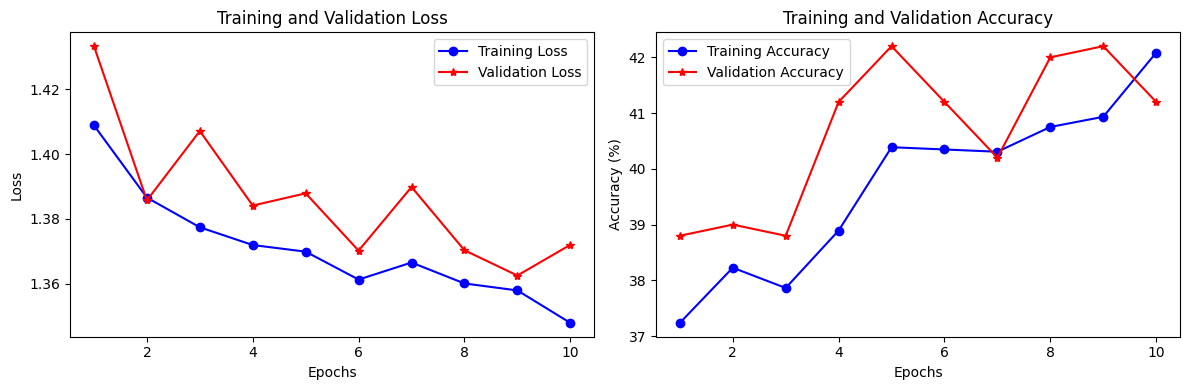

In [42]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 4.2
Hidden Layer Design: LSTM\
Aggregation Method: Using the last hidden layer as the final representation of the sentence

In [43]:
# Define model 4.2 architecture
class QuestionClassifierModel4_2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel4_2, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)  # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the representation of the last word
        out, (hidden, cell) = self.hidden(x)
        x = hidden[0]  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [44]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel4_2(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
patience = 10

In [45]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/100, Train Loss: 1.4145, Dev Loss: 1.4046, Train Accuracy: 37.74%, Dev Accuracy: 38.60%
Macro F1 Score: 0.11522591645353794
Micro F1 Score: 0.386
Epoch 2/100, Train Loss: 1.3854, Dev Loss: 1.4151, Train Accuracy: 38.23%, Dev Accuracy: 34.00%
Macro F1 Score: 0.161835668609768
Micro F1 Score: 0.363
Epoch 3/100, Train Loss: 1.3730, Dev Loss: 1.3856, Train Accuracy: 39.22%, Dev Accuracy: 41.00%
Macro F1 Score: 0.17552654449496527
Micro F1 Score: 0.37866666666666665
Epoch 4/100, Train Loss: 1.3641, Dev Loss: 1.3753, Train Accuracy: 39.94%, Dev Accuracy: 40.80%
Macro F1 Score: 0.178641525086535
Micro F1 Score: 0.386
Epoch 5/100, Train Loss: 1.3653, Dev Loss: 1.3860, Train Accuracy: 40.02%, Dev Accuracy: 38.80%
Macro F1 Score: 0.17468882399203894
Micro F1 Score: 0.3864
Epoch 6/100, Train Loss: 1.3626, Dev Loss: 1.3647, Train Accuracy: 39.94%, Dev Accuracy: 40.80%
Macro F1 Score: 0.17311532032678248
Micro F1 Score: 0.39
Epoch 7/100, Train Loss: 1.3562, Dev Loss: 1.3597, Train Accuracy:

In [46]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.4674, Test Accuracy: 86.80%
Macro F1 Score on Test Set: 0.8511905925581331
Micro F1 Score on Test Set: 0.868


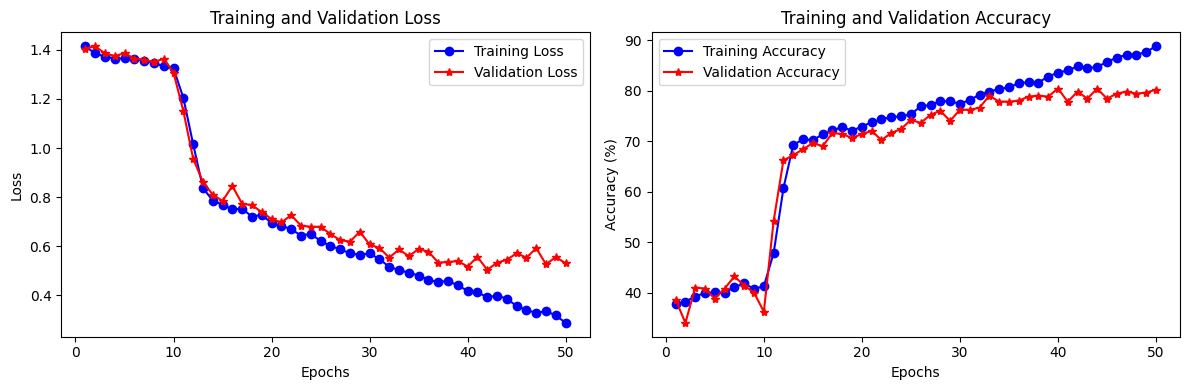

In [47]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 5
Hidden Layer Design: BiLSTM\
Aggregation Method: Using the last hidden layer as the final representation of the sentence

In [48]:
# Define model 5 architecture
class QuestionClassifierModel5(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel5, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)  # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the mean of the two last hidden layers as the final representation
        out, (hidden, cell) = self.hidden(x)
        forward_hidden, backward_hidden = hidden.chunk(2, 0)
        average_hidden = torch.mean(torch.cat((forward_hidden, backward_hidden), dim=0), dim=0)
        # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(average_hidden)  # Now, shape: batch_size x output_dim
        
        return x

In [49]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel5(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
patience = 5

In [50]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/50, Train Loss: 1.2191, Dev Loss: 1.0598, Train Accuracy: 49.62%, Dev Accuracy: 57.20%
Macro F1 Score: 0.42786482644709006
Micro F1 Score: 0.572
Epoch 2/50, Train Loss: 0.9088, Dev Loss: 0.8713, Train Accuracy: 63.57%, Dev Accuracy: 66.00%
Macro F1 Score: 0.47091774339316217
Micro F1 Score: 0.616
Epoch 3/50, Train Loss: 0.7756, Dev Loss: 0.7979, Train Accuracy: 69.49%, Dev Accuracy: 67.20%
Macro F1 Score: 0.4982456168860572
Micro F1 Score: 0.6346666666666667
Epoch 4/50, Train Loss: 0.6978, Dev Loss: 0.7155, Train Accuracy: 72.31%, Dev Accuracy: 72.20%
Macro F1 Score: 0.521129012050992
Micro F1 Score: 0.6565
Epoch 5/50, Train Loss: 0.6504, Dev Loss: 0.7385, Train Accuracy: 74.82%, Dev Accuracy: 74.20%
Macro F1 Score: 0.5372141250953424
Micro F1 Score: 0.6736
Epoch 6/50, Train Loss: 0.6148, Dev Loss: 0.6919, Train Accuracy: 76.03%, Dev Accuracy: 73.00%
Macro F1 Score: 0.5680244757054842
Micro F1 Score: 0.683
Epoch 7/50, Train Loss: 0.5632, Dev Loss: 0.6954, Train Accuracy: 78.13%

In [51]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.4979, Test Accuracy: 81.80%
Macro F1 Score on Test Set: 0.7765062561103973
Micro F1 Score on Test Set: 0.818


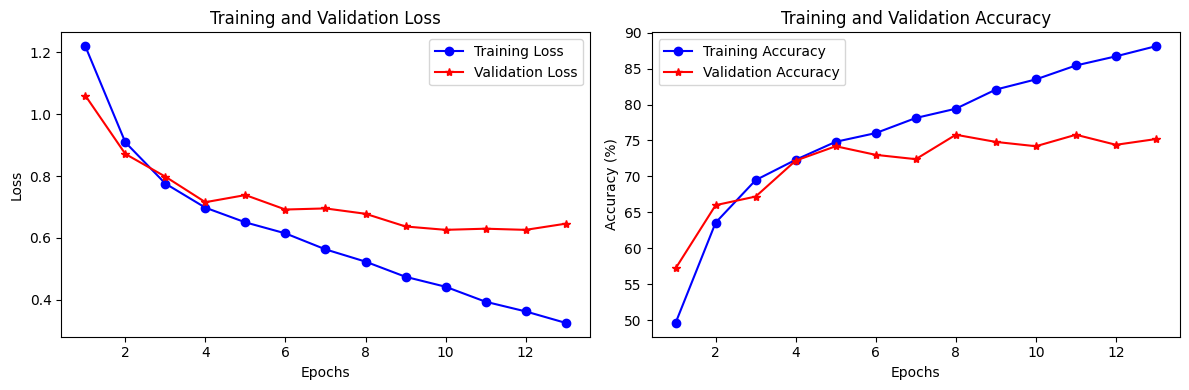

In [52]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 6
Hidden Layer: Transformer Encoder\
Aggregation: Average pooling

In [53]:
# Define model 6 architecture
class QuestionClassifierModel6(nn.Module):
    def __init__(self, embedding_dim, output_dim, num_layers, num_heads, dropout_rate):
        super(QuestionClassifierModel6, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output Layer
        self.output = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)  # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer
        x = self.transformer_encoder(x)
        x = x.mean(dim=1) # Global average pooling

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [54]:
# Define hyperparameters
EMBEDDING_DIM = 300
# HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 3
NUM_HEADS = 6
DROPOUT_RATE = 0.1

model = QuestionClassifierModel6(EMBEDDING_DIM, LABELSET_SIZE, HIDDEN_LAYERS, NUM_HEADS, DROPOUT_RATE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 50
patience = 5

/p/scratch/ccstdl/xu17/miniconda3/envs/jz/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [55]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer, patience)

Epoch 1/50, Train Loss: 1.4045, Dev Loss: 1.3969, Train Accuracy: 37.36%, Dev Accuracy: 37.80%
Macro F1 Score: 0.1833979987747601
Micro F1 Score: 0.378
Epoch 2/50, Train Loss: 1.3515, Dev Loss: 1.3492, Train Accuracy: 40.37%, Dev Accuracy: 43.00%
Macro F1 Score: 0.18994570702859642
Micro F1 Score: 0.404
Epoch 3/50, Train Loss: 1.2881, Dev Loss: 1.2919, Train Accuracy: 45.96%, Dev Accuracy: 45.40%
Macro F1 Score: 0.21767185120789936
Micro F1 Score: 0.42066666666666674
Epoch 4/50, Train Loss: 1.2457, Dev Loss: 1.2638, Train Accuracy: 48.42%, Dev Accuracy: 50.00%
Macro F1 Score: 0.2573923624515951
Micro F1 Score: 0.4405
Epoch 5/50, Train Loss: 1.2187, Dev Loss: 1.2333, Train Accuracy: 51.05%, Dev Accuracy: 51.80%
Macro F1 Score: 0.28610118740119433
Micro F1 Score: 0.456
Epoch 6/50, Train Loss: 1.1936, Dev Loss: 1.2024, Train Accuracy: 52.77%, Dev Accuracy: 52.80%
Macro F1 Score: 0.3019703626340928
Micro F1 Score: 0.468
Epoch 7/50, Train Loss: 1.1640, Dev Loss: 1.1778, Train Accuracy: 54.6

In [56]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.8441, Test Accuracy: 67.20%
Macro F1 Score on Test Set: 0.5521706417948252
Micro F1 Score on Test Set: 0.672


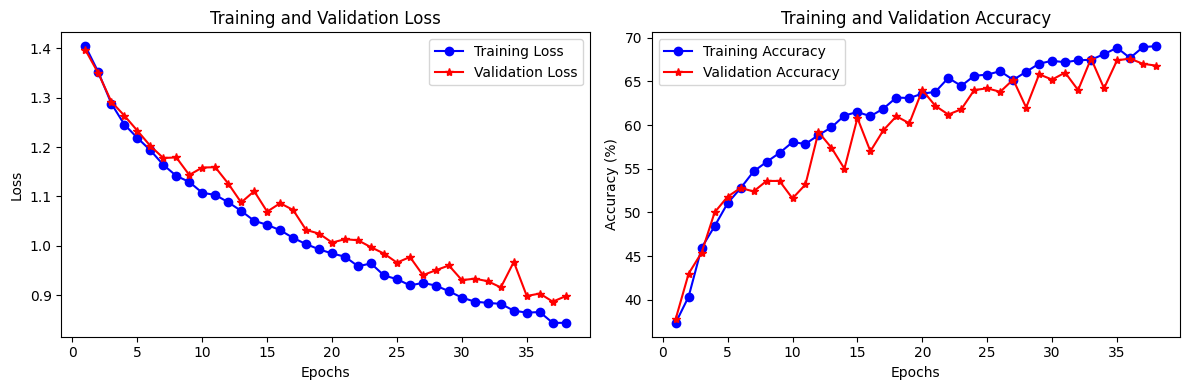

In [57]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)